In [1]:
#Load packages
import pulp
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

C:\Users\zhout\AppData\Local\Temp\ipykernel_18564\3455868279.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
battery_specs = pd.read_csv(os.path.join('data', 'battery_specs.csv'), index_col=0)
battery_specs

,Values,Units
Max charging rate,2,MW
Max discharging rate,2,MW
Max storage volume,4,MWh
Battery charging efficiency,0.05,NaN
Battery discharging efficiency,0.05,NaN
Lifetime (1),10,years
Lifetime (2),5000,cycles
Storage volume degradation rate,0.001,%/cycle
Capex,500000,£
Fixed Operational Costs,"£5,000",£/year


In [3]:
daily_data = pd.read_csv(os.path.join('data', 'daily_data.csv'))
daily_data.head()

,Datetime,Market 3 Price [£/MWh]
0,1/1/2018,48.6
1,1/2/2018,49.6
2,1/3/2018,48.2
3,1/4/2018,50.4
4,1/5/2018,55.0


In [4]:
small_data = daily_data.iloc[:24]
prices = small_data['Market 3 Price [£/MWh]'].to_list()

In [5]:
float(battery_specs.loc['Max charging rate', 'Values'])

2.0

In [8]:
prob = pulp.LpProblem("battery_problem", pulp.LpMaximize)

time_horizon = 24
times = list(range(time_horizon))
K_C = 2 # MW
K_D = 2
Capacity = 4
S_init = 0
eta_C = 0.95
eta_D = 0.95
charge = pulp.LpVariable.dicts("Charge", [f'C_t_{t}' for t in times], lowBound=0, upBound=K_C, cat='Continuous')
discharge = pulp.LpVariable.dicts("Discharge", [f'D_t_{t}' for t in times], lowBound=0, upBound=K_D, cat='Continuous')

# objective function
# profit = revenue - cost = discharge * price - charge * price
prob += \
    pulp.LpAffineExpression([(discharge[f'D_t_{t}'], prices[t]) for t in times])  +\
    pulp.LpAffineExpression([(charge[f'C_t_{t}'],   -prices[t]) for t in times])

# constraints
# 1. storage constraint, 0 <= S_t <= Capacity

for t in times:
    # min capacity
    prob += \
        S_init +\
        pulp.LpAffineExpression([(charge[f'C_t_{i}'],     eta_C) for i in range(t)]) +\
        pulp.LpAffineExpression([(discharge[f'D_t_{i}'], -eta_C) for i in range(t)]) \
        >= 0
    
    # max capacity
    prob += \
        S_init +\
        pulp.LpAffineExpression([(charge[f'C_t_{i}'],     eta_C) for i in range(t)]) +\
        pulp.LpAffineExpression([(discharge[f'D_t_{i}'], -eta_C) for i in range(t)]) \
        <= Capacity
    
prob.solve()

for v in prob.variables():
    print(v.name, "=", v.varValue)

# The optimised objective function value is printed to the screen
print("Total profit = ", pulp.value(prob.objective))

Charge_C_t_0 = 2.0
Charge_C_t_1 = 0.21052632
Charge_C_t_10 = 0.0
Charge_C_t_11 = 0.21052632
Charge_C_t_12 = 2.0
Charge_C_t_13 = 2.0
Charge_C_t_14 = 2.0
Charge_C_t_15 = 0.0
Charge_C_t_16 = 2.0
Charge_C_t_17 = 2.0
Charge_C_t_18 = 0.0
Charge_C_t_19 = 0.0
Charge_C_t_2 = 2.0
Charge_C_t_20 = 1.7894737
Charge_C_t_21 = 0.0
Charge_C_t_22 = 0.0
Charge_C_t_23 = 0.0
Charge_C_t_3 = 0.0
Charge_C_t_4 = 0.0
Charge_C_t_5 = 2.0
Charge_C_t_6 = 2.0
Charge_C_t_7 = 0.0
Charge_C_t_8 = 2.0
Charge_C_t_9 = 0.0
Discharge_D_t_0 = 0.0
Discharge_D_t_1 = 0.0
Discharge_D_t_10 = 2.0
Discharge_D_t_11 = 0.0
Discharge_D_t_12 = 0.0
Discharge_D_t_13 = 0.0
Discharge_D_t_14 = 2.0
Discharge_D_t_15 = 2.0
Discharge_D_t_16 = 0.0
Discharge_D_t_17 = 2.0
Discharge_D_t_18 = 2.0
Discharge_D_t_19 = 2.0
Discharge_D_t_2 = 0.0
Discharge_D_t_20 = 2.0
Discharge_D_t_21 = 0.0
Discharge_D_t_22 = 0.0
Discharge_D_t_23 = 2.0
Discharge_D_t_3 = 0.0
Discharge_D_t_4 = 2.0
Discharge_D_t_5 = 2.0
Discharge_D_t_6 = 0.0
Discharge_D_t_7 = 2.0
Discharge_D_

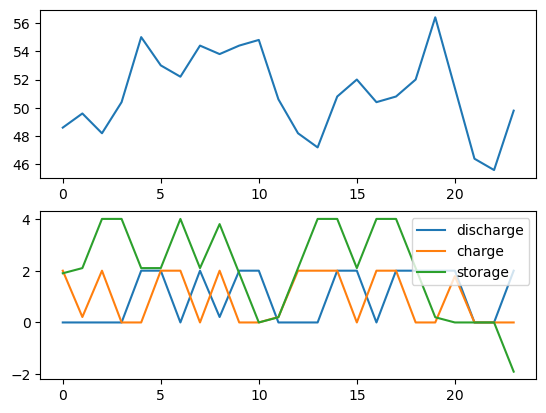

In [9]:
charge_values = [charge[f'C_t_{t}'].varValue for t in times] 
discharge_values = [discharge[f'D_t_{t}'].varValue for t in times]
storage_values = [S_init,]
for t in times:
    S_t = storage_values[-1] + eta_C * charge_values[t] - eta_D * discharge_values[t]
    storage_values.append(S_t)
storage_values.pop(0)

fig, axs = plt.subplots(2, 1)
axs[0].plot(np.arange(len(prices)), prices)
axs[1].plot(np.arange(len(prices)), discharge_values, label='discharge')
axs[1].plot(np.arange(len(prices)), charge_values, label='charge')
axs[1].plot(np.arange(len(prices)), storage_values, label='storage')
plt.legend()

# handling daily vs hourly data

- At time t, make discharge and charge for hourly market
- At time t%24 = 0, make discharge and charge for daily market
- At time t%24 =/= 0, charging and discharging for daily market proceeds at rate of c/24 & d/24 using rate set at t//24